## Install packages and libraries

In [2]:
# Install the Pyomo package and the CBC solver to use within this notebook
_ = !sudo apt install -qq libglpk-dev python3.8-dev libgmp3-dev
_ = !apt-get install -y -qq coinor-cbc
_ = !pip install -q pyomo

import numpy as np
import pandas as pd
import pyomo
import pyomo.environ as pyo
import pyomo.gdp as gdp
from IPython.display import Markdown
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import truncnorm
import requests
import types
import time
from pyomo.environ import SolverFactory


In [3]:
# Use CBC solver
solver = SolverFactory('cbc', executable='/usr/bin/cbc')

## Mount drive before continuing

### Read in data

In [4]:
car_data = pd.read_csv('/content/drive/MyDrive/MOPTA/MOPTA2023_car_locations.csv')
car_data = np.array(car_data)

## Define structure of individuals and population

In [186]:
# Define individual structures

n_individual = 600 # stations in an individual
pop_size = 1 # number of individuals
x_max = 290 # size of search space on x axis
y_max = 150 # size of search space on y axis
max_chargers = 8 # max number of chargers at a station

generations = 10

# cost parameters
driving_cost_per_mile = 0.041
charging_cost_per_mile = 0.0388
construction_cost_per_station = 5000
maintenance_fee_per_charger = 500

# define the population
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# uniform distribution for generating random points in the search space
ud_x = uniform(0, x_max)
ud_y = uniform(0, y_max)

# uniform distribution for generating random number between 0 and 1
ud = uniform(0,1)

# global best station positions
global_best_stations = np.array([[ud_x.rvs(1)[0],ud_y.rvs(1)[0]] for i in range(n_individual)]) # position of every station in the global best
# global best score
global_best_score = 1000000000

local_best_scores = [1e9 for i in range(pop_size)] # storing local best scores (not positions)

class Individual:

  def __init__(self, ident, positions, chargers, velocities):
    self.ident = ident
    self.positions = positions # numpy array of x,y positions of all stations
    self.chargers = chargers # numpy array of number of chargers per station
    self.velocities = velocities # numpy array of x,y velocity of each station
    self.best_positions = np.array([[ud_x.rvs(1), ud_y.rvs(1)] for i in range(self.positions.shape[0])]).reshape(n_individual, 2) # numpy array of best configuration for the station
    self.cost = 0

  def update_positions(self, global_best_stations): # global best stations must be a numpy array with x,y coords of the best global configuration
    inertia_components = options['w'] * (self.velocities)
    cognitive_components = ud.rvs(1) * options['c1'] * (self.best_positions - self.positions)
    social_components = ud.rvs(1) * options['c2'] * (global_best_stations - self.positions)

    new_velocities = inertia_components + cognitive_components + social_components
    new_positions = new_velocities + self.positions

    # Replace out-of-range x,y values with random values between 0 and x_max,y_max
    if new_positions[new_positions[:,0] > x_max].shape[0] > 0:
      new_positions[new_positions[:, 0] > x_max, 0] = np.random.uniform(0, x_max, size=np.sum(new_positions[:, 0] > x_max))
    if new_positions[new_positions[:,1] > y_max].shape[0] > 0:
      new_positions[new_positions[:, 1] > y_max, 1] = np.random.uniform(0, y_max, size=np.sum(new_positions[:, 1] > y_max))
    if new_positions[new_positions[:,0] < 0].shape[0] > 0:
      new_positions[new_positions[:, 0] < 0, 0] = np.random.uniform(0, x_max, size=np.sum(new_positions[:, 0] < 0))
    if new_positions[new_positions[:,1] < 0].shape[0] > 0:
      new_positions[new_positions[:, 1] < 0, 1] = np.random.uniform(0, y_max, size=np.sum(new_positions[:, 1] < 0))

    new_positions.reshape(n_individual, 2)

    self.positions = new_positions
    self.velocities = new_velocities

### Generate population

In [187]:
nd = norm(10,5) # normal distribution for sampling velocities
population = {} # empty dictionary to fill with individuals to make population
for i in range(pop_size):
  # generating random x,y positions for the individual stations
  positions = np.dstack([ud_x.rvs(n_individual), ud_y.rvs(n_individual)]).reshape(n_individual,2)
  velocities=nd.rvs(size=(n_individual, 2)) # sampling velocities from random dist
  population.update({i : Individual(ident=i,
                                    positions=positions,
                                    chargers=np.random.choice(list(range(1,9))),
                                    velocities=velocities)}
                    )
  

population[0].velocities

array([[18.92074938,  9.74567929],
       [ 8.04938202,  6.73644996],
       [18.9908686 , 17.18972914],
       ...,
       [12.46897378,  7.71190301],
       [ 6.34244343, 10.75114008],
       [14.20575127, 10.2112405 ]])

### Sample vehicle ranges

In [188]:
# get sample of vehicle ranges
min_range = 20
max_range = 250
mean_range = 100
sd_range = 50

# sample ranges for each vehicle
def get_samples(min_range=min_range,
                max_range=max_range,
                mean_range=mean_range,
                sd_range=sd_range):
    pd = truncnorm((min_range - mean_range) / sd_range, 
                   (max_range - mean_range) / sd_range, 
                   loc=mean_range, scale=sd_range)
    samples = pd.rvs(size=(car_data.shape[0], 10))
    samples_aggregated = np.mean(samples, axis=1)

    return samples_aggregated

# ranges sampled
samples = get_samples()

## Evaluation function

In [189]:
def compute_visiting_probability(ranges:np.array, lam:float=0.012):
    return np.exp(-lam**2 * (ranges - 20)**2 )

# Calculate the pairwise distances between points in the two arrays
def calculate_distance(car_location, station_location):
    return np.linalg.norm(car_location - station_location, axis=1)

def MIP(vehicles, stations, distances, v_b):
  L = 8

  M = 500

  m = pyo.ConcreteModel('vehicle assignment')

  m.VEHICLES = pyo.Set(initialize = vehicles.keys())
  m.STATIONS = pyo.Set(initialize = stations.keys())

  m.x = pyo.Var(m.VEHICLES * m.STATIONS, domain=pyo.Binary)

  @m.Objective(sense=pyo.minimize)
  def minimize_allocation(m):
      return sum(m.x[vehicle, station] * (distances[vehicle, station] + v_b[vehicle] * M) for vehicle in m.VEHICLES for station in m.STATIONS)   #sum(m.past[job] for job in m.JOBS)

  @m.Constraint(m.STATIONS)
  def max_chargers(m, station):
      # return sum(m.x[v, station] * c[v] for v in m.VEHICLES) <= L
      return sum(m.x[v, station] for v in m.VEHICLES) <= L

  @m.Constraint(m.VEHICLES)
  def single_allocation(m, vehicle):
      return sum(m.x[vehicle, s] for s in m.STATIONS) == 1

  @m.Constraint(m.VEHICLES, m.STATIONS)
  def max_range(m, vehicle, station):
      return m.x[vehicle, station] * distances[vehicle, station] <= 100

  result = solver.solve(m)

  Z = np.zeros((max(vehicles)+1, max(stations)+1))
  for i in m.VEHICLES:
    for j in m.STATIONS:
      Z[i, j] = m.x[i, j]()

  return m.minimize_allocation(), Z

In [190]:
def solve_MIP(population, car_data, local_best_scores):
  for i in range(len(population.keys())):
    # sample vehicle ranges
    ranges = get_samples()

    # get visiting probabilities
    c = compute_visiting_probability(ranges)
    # number of vehicles per batch
    v_b = c * 10
    # exclude vehicles with a low probability of charging
    exclusion = 0.3*10

    # vehicle batches which have a strong enough probability of visiting a charger
    applicable_vehicles = np.array([v for v in range(v_b.shape[0]) if v_b[v] > exclusion])
    vehicle_positions = car_data[applicable_vehicles]
    vehicle_dict = {j : vehicle_positions[j] for j in range(vehicle_positions.shape[0])}

    # station positions
    station_dict = {j : population[i].positions[j] for j in range(n_individual)}
    
    distances = np.zeros((vehicle_positions.shape[0], n_individual))
    for s in range(n_individual):
        distances[:,s] = calculate_distance(vehicle_positions, population[i].positions[s])

    obj, X = MIP(vehicle_dict, station_dict, distances, v_b)

    # counting how many stations are active and subsequent cost
    active_stations = [j for j in range(X.shape[1]) if np.sum(X[:, j]) > 0]
    active_station_cost = construction_cost_per_station * len(active_stations)

    total_cost = active_station_cost + obj

    population[i].cost = total_cost

    if total_cost < local_best_scores[i]:
      local_best_scores[i] = total_cost
      population[i].best_positions = population[i].positions


In [191]:
def evaluate(population, vehicles, global_best_score, global_best_stations, local_best_scores):
    '''
    this function is where we run a MIP to solve the station size problem and then evaluate the total cost

    The vehicle-->station assignments must be made in this function
    '''

    print('Solving assignment problem...')
    solve_MIP(population, vehicles, local_best_scores)
    print('Assignment solved for population')

    population_fitness = []
    for i in population:
      population_fitness.append(population[i].cost)

    
    print("Population fitness: ", population_fitness)
    
    if max(population_fitness) <= global_best_score:
      global_best_score = max(population_fitness)
      global_best_stations = population[np.argmax(population_fitness)].positions
      print('Updated global best')
    print("Evaluation Complete\n----------------------------")
    
    return global_best_score, global_best_stations, local_best_scores

In [192]:
# evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores)

In [193]:
for gen in range(generations):

  global_best_score, global_best_stations, local_best_scores = evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores)

  for ind in population:
    population[ind].update_positions(global_best_stations)

Solving assignment problem...
Assignment solved for population
Population fitness:  [2224351.204102395]
Updated global best
Evaluation Complete
----------------------------
Solving assignment problem...
Assignment solved for population
Population fitness:  [2246574.6962350816]
Evaluation Complete
----------------------------
Solving assignment problem...
Assignment solved for population
Population fitness:  [2087997.790473562]
Updated global best
Evaluation Complete
----------------------------
Solving assignment problem...
Assignment solved for population
Population fitness:  [2159984.608158535]
Evaluation Complete
----------------------------
Solving assignment problem...
Assignment solved for population
Population fitness:  [2031938.1664931644]
Updated global best
Evaluation Complete
----------------------------
Solving assignment problem...
Assignment solved for population
Population fitness:  [2036476.118998086]
Evaluation Complete
----------------------------
Solving assignment p

Text(0.5, 0, 'Generation')

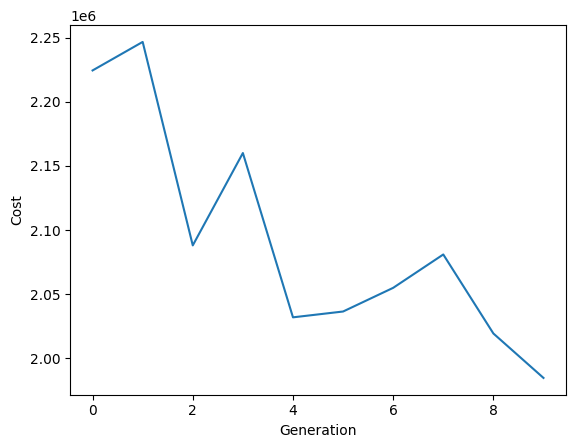

In [195]:
plt.plot([2224351.204102395, 
          2246574.6962350816,
          2087997.790473562,
          2159984.608158535,
          2031938.1664931644,
          2036476.118998086,
          2054931.4231311667,
          2080929.9166139835,
          2019351.0023448777,
          1984720.736706721])
plt.ylabel('Cost')
plt.xlabel('Generation')